In [32]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML
import pandas as pd


In [33]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,27 mins 33 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_n3uvuo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,179.0 Mb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


In [38]:
df = h2o.import_file('../Data/titanic/no_nan_no_real.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [36]:
df.describe()

Rows:891
Cols:19




,C1,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_female,Sex_male
type,int,int,int,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,445.0,446.0,0.3838383838383838,2.3086419753086447,29.12233445566779,0.5230078563411893,0.3815937149270483,32.20420796857465,0.18855218855218855,0.08641975308641975,0.7250280583613917,0.04489337822671156,0.20650953984287318,0.5802469135802469,0.1425364758698092,0.020202020202020204,0.005611672278338945,0.35241301907968575,0.6475869809203143
maxs,890.0,891.0,1.0,3.0,80.0,8.0,6.0,512.3292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,257.3538420152301,257.3538420152301,0.4865924542648575,0.8360712409770491,13.503127625398086,1.1027434322934315,0.8060572211299488,49.69342859718089,0.3913721645054733,0.28114069214170423,0.44675091003414663,0.20718624545180953,0.40502773475420806,0.4937956017104174,0.34979587557158587,0.14076980825895344,0.07474256671626399,0.4779900708960982,0.4779900708960982
zeros,1,0,549,0,7,608,678,15,723,814,245,851,707,374,764,873,886,577,314
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,1.0,0.0,3.0,22.0,1.0,0.0,7.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2.0,3.0,1.0,3.0,26.0,0.0,0.0,7.925,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [67]:
predictors=[]
for col in df.columns:
    if col != 'Survived':
        df[col] = df[col].asfactor()
        predictors.append(col)
response = "Survived"

# split into train and validation sets
train, valid = df.split_frame(ratios = [.8], seed = 1234)

# train your model
titanic_gbm = H2OGradientBoostingEstimator(sample_rate = .7, seed = 1234)
titanic_gbm.train(x = predictors,
                   y = response,
                   training_frame = train,
                   validation_frame = valid)

# retrieve the model performance
perf = titanic_gbm.model_performance(valid)
perf

gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.42852100123306475
RMSE: 0.6546151550591116
MAE: 0.43043549970345824
RMSLE: 0.45336100711129357
Mean Residual Deviance: 0.42852100123306475


In [69]:
pred = titanic_gbm.predict(valid)
print(pred.head())
valid_df = valid.as_data_frame().Survived
print(valid_df.head)
for i in range(pred.nrows):
    print(i)
    print(pred.nrows)
    if pred[1]==valid[i][1]:
        print ("oui")

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818
0.00191818



<bound method NDFrame.head of 0      1
1      1
2      0
3      1
4      0
      ..
174    0
175    0
176    0
177    1
178    0
Name: Survived, Length: 179, dtype: int64>
0
179


IndexError: list index out of range

In [47]:
titanic_gbm.accuracy(valid)

AttributeError: type object 'ModelBase' has no attribute 'accuracy'

In [13]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [14]:
metalearner.coef_norm()


{'Intercept': 0.38383838383838514,
 'GBM_2_AutoML_20200525_094821': 0.03768821141747835,
 'GBM_1_AutoML_20200525_094821': 0.1189665616547566,
 'GBM_4_AutoML_20200525_094821': 0.03466007835497838,
 'GBM_3_AutoML_20200525_094821': 0.03076558328153724,
 'GLM_1_AutoML_20200525_094821': 0.12432937485703542,
 'DRF_1_AutoML_20200525_094821': 0.0,
 'GBM_5_AutoML_20200525_094821': 0.0,
 'XGBoost_3_AutoML_20200525_094821': 0.0,
 'XGBoost_2_AutoML_20200525_094821': 0.0,
 'XGBoost_1_AutoML_20200525_094821': 0.0}

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


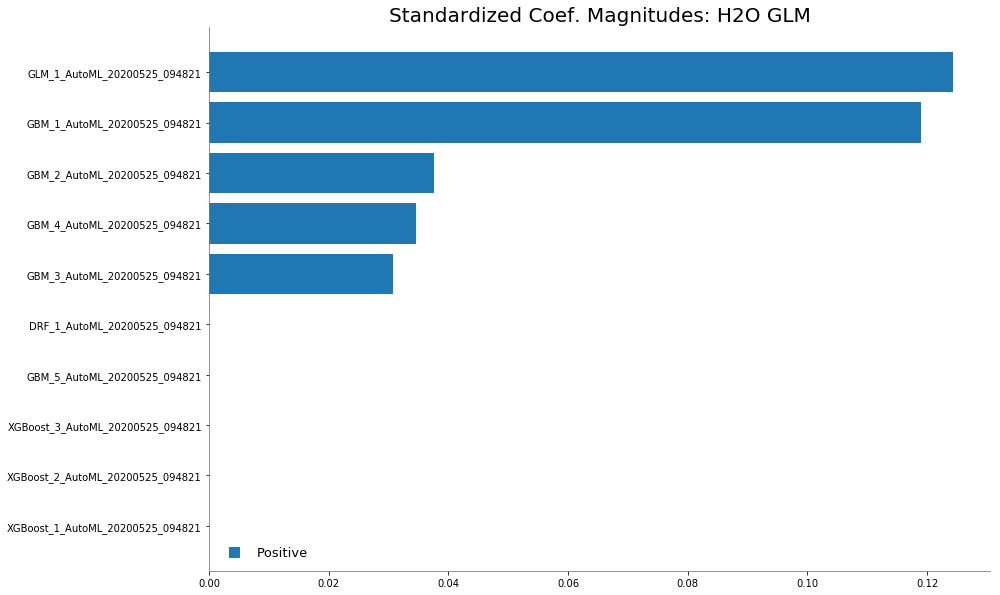

In [15]:
%matplotlib inline
metalearner.std_coef_plot()